# 1. Prescription Problem Statement

The opioid epidemic in the United States was recently declared a national emergency as it affects a broad demographic of men and women with no evidence of abating. The problem is believed to have begun as a result of overprescribing powerful opioids starting in the 1990s to treat chronic pain. The number of Americans dying from opioid overdose has increased roughly four-fold over a 15 year period (1999 – 2014). Despite the high prevalence of substance use disorders among patients in various medical care settings, health care professionals do not routinely screen for substance use disorders, even though these patients are at higher risk for development of chronic medical illnesses and potentially fatal medication interactions (1). Identifying medical specialties and prescriber characteristics associated with a high rate of opioid prescriptions would identify potential target patient populations for public health education and health care settings that can implement new medical guidelines to help stem the rise in substance use disorders and overdoses.

The Centers for Medicare & Medicaid Services (CMS) released a public dataset, the Part D Prescriber Public Use File with information on prescription drug events incurred by Medicare beneficiaries with a Part D prescription drug plan. The dataset covers calendar year 2015 and contains beneficiary counts, claim counts, drug names, drug costs, and provider’s unique identifier, practice location, and medical specialty. Supplementary and summary tables additionally provide additional provider demographics, claim counts and drug costs by plan type, opioid or other drug classes, and beneficiary age and race counts.

While this data can help provide insights into opioid prescriber characteristics, results may not be generalizable to all medical professionals within the United States. CMS provide prescriptions made for patients 65 years of age or older and is limited to those enrolled in the Medicare Part D prescription drug program, which is ~70% of all Medicare beneficiaries. Prescriber behavior may differ for patients younger than 65 years of age and/or for patients with private insurance plans. Data are also limited to a single calendar year, which will not detect changes in provider behavior due to the recognition of the opioid epidemic.

(1) “Facing Addition in America” The Surgeon General’s Report on Alcohol, Drugs, and Health (2016) U.S. Department of Health & Human Services

### Set up analytic environment

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

### Import and handle missing values

In [3]:
# Import Part D Prescriber Demographic dataset
df_demo = pd.read_csv("../unit-4_project/PartD_Prescriber_PUF_NPI_15/PartD_Prescriber_PUF_NPI_15.txt", sep='\t')
df_demo.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_credentials,nppes_provider_gender,nppes_entity_code,nppes_provider_street1,nppes_provider_street2,nppes_provider_city,...,beneficiary_male_count,beneficiary_race_white_count,beneficiary_race_black_count,beneficiary_race_asian_pi_count,beneficiary_race_hispanic_count,beneficiary_race_nat_ind_count,beneficiary_race_other_count,beneficiary_nondual_count,beneficiary_dual_count,beneficiary_average_risk_score
0,1912175340,&H'S)U,&E'K:(A:I,NaN,MD,M,I,301 THE ALAMEDA UNIT 82,NaN,SAN JUAN BAUTISTA,...,21.0,NaN,NaN,NaN,25.0,0.0,NaN,24.0,28.0,1.2440
1,1417051921,A,N,D,PA-C,F,I,522 HEATHER RIDGE,NaN,CATOOSA,...,68.0,166.0,0.0,0.0,NaN,NaN,NaN,149.0,46.0,0.8248
2,1952310666,A'BODJEDI,ENENGE,NaN,MD,M,I,ONE HOSPITAL PLAZA,NaN,STAMFORD,...,79.0,88.0,NaN,NaN,73.0,0.0,NaN,34.0,178.0,1.3073
3,1760465553,A. SATTAR,MUHAMMAD,A,MD,M,I,3310 LIVE OAK ST,COOC FLOAT,DALLAS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1467482471,AAB,BARRY,N,D.D.S.,M,I,1101 DEFIANCE ST,NaN,WAPAKONETA,...,12.0,27.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.9579


In [4]:
# Summary about this DataFrame
df_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1102268 entries, 0 to 1102267
Data columns (total 84 columns):
npi                                 1102268 non-null int64
nppes_provider_last_org_name        1102242 non-null object
nppes_provider_first_name           1102234 non-null object
nppes_provider_mi                   791132 non-null object
nppes_credentials                   1050602 non-null object
nppes_provider_gender               1102249 non-null object
nppes_entity_code                   1102268 non-null object
nppes_provider_street1              1102268 non-null object
nppes_provider_street2              455378 non-null object
nppes_provider_city                 1102268 non-null object
nppes_provider_zip5                 1102207 non-null float64
nppes_provider_zip4                 981483 non-null float64
nppes_provider_state                1102268 non-null object
nppes_provider_country              1102268 non-null object
specialty_description               1102268 non-n

In [5]:
###ASSUMPTION: Cultural differences in healthcare usage, prescribing behavior, and/or addiction outside of the US may differ
# Therefore, filter DataFrame to exclude providers that are outside of the 50 US states and DC
# 1. create a Boolean object 'excl_state' where rows for areas that will be excluded are set to True
excl_state = df_demo['nppes_provider_state'].isin(['XX','AA','AE','AP','AS','GU','MP','PR','VI','ZZ'])
# 2. Keep only rows that are set to False for 'excl_state'
df_demo = df_demo[~excl_state]
# 3. Confirm that only the US is represented within this DataFrame
print df_demo.nppes_provider_country.value_counts()

US    1090979
Name: nppes_provider_country, dtype: int64


In [6]:
# Remove columns not likely used for analysis (including those too cumbersome to figure out how to fill the NaN)
df_demo.drop(['nppes_provider_last_org_name', 'nppes_provider_first_name','nppes_provider_mi','nppes_entity_code','nppes_provider_street1','nppes_provider_street2','nppes_provider_zip4','nppes_provider_country',
              'antibiotic_claim_count','antibiotic_drug_cost','antibiotic_bene_count','hrm_ge65_suppress_flag','hrm_claim_count_ge65','hrm_drug_cost_ge65','hrm_bene_ge65_suppress_flag','hrm_bene_count_ge65',
              'beneficiary_age_65_74_count','beneficiary_age_75_84_count','beneficiary_age_greater_84_count','nppes_credentials','brand_suppress_flag','brand_claim_count','brand_drug_cost','description_flag',
              'generic_suppress_flag','generic_claim_count','generic_drug_cost','other_suppress_flag','other_claim_count','other_drug_cost','antipsych_ge65_suppress_flag','antipsych_claim_count_ge65',
              'antipsych_drug_cost_ge65','antipsych_bene_ge65_suppress_flg','antipsych_bene_count_ge65','beneficiary_age_less_65_count','beneficiary_nondual_count','beneficiary_dual_count',
              'beneficiary_race_black_count','beneficiary_race_asian_pi_count','beneficiary_race_hispanic_count','beneficiary_race_nat_ind_count','beneficiary_race_other_count'], axis=1, inplace=True)
df_demo.columns

Index([u'npi', u'nppes_provider_gender', u'nppes_provider_city',
       u'nppes_provider_zip5', u'nppes_provider_state',
       u'specialty_description', u'medicare_prvdr_enroll_status',
       u'total_claim_count', u'total_30_day_fill_count', u'total_drug_cost',
       u'total_day_supply', u'bene_count', u'ge65_suppress_flag',
       u'total_claim_count_ge65', u'total_30_day_fill_count_ge65',
       u'total_drug_cost_ge65', u'total_day_supply_ge65',
       u'bene_count_ge65_suppress_flag', u'bene_count_ge65',
       u'mapd_suppress_flag', u'mapd_claim_count', u'mapd_drug_cost',
       u'pdp_suppress_flag', u'pdp_claim_count', u'pdp_drug_cost',
       u'lis_suppress_flag', u'lis_claim_count', u'lis_drug_cost',
       u'nonlis_suppress_flag', u'nonlis_claim_count', u'nonlis_drug_cost',
       u'opioid_claim_count', u'opioid_drug_cost', u'opioid_day_supply',
       u'opioid_bene_count', u'opioid_prescriber_rate',
       u'average_age_of_beneficiaries', u'beneficiary_female_count',
      

In [7]:
# Identify which columns contain null values
for column in df_demo.columns:
    print column, df_demo[column].isnull().sum()

npi 0
nppes_provider_gender 19
nppes_provider_city 0
nppes_provider_zip5 0
nppes_provider_state 0
specialty_description 0
medicare_prvdr_enroll_status 0
total_claim_count 0
total_30_day_fill_count 0
total_drug_cost 0
total_day_supply 0
bene_count 132390
ge65_suppress_flag 854403
total_claim_count_ge65 236576
total_30_day_fill_count_ge65 236576
total_drug_cost_ge65 236576
total_day_supply_ge65 236576
bene_count_ge65_suppress_flag 611144
bene_count_ge65 479835
mapd_suppress_flag 864273
mapd_claim_count 226706
mapd_drug_cost 226706
pdp_suppress_flag 864273
pdp_claim_count 226706
pdp_drug_cost 226706
lis_suppress_flag 862642
lis_claim_count 228337
lis_drug_cost 228337
nonlis_suppress_flag 862642
nonlis_claim_count 228337
nonlis_drug_cost 228337
opioid_claim_count 310618
opioid_drug_cost 310618
opioid_day_supply 310618
opioid_bene_count 368367
opioid_prescriber_rate 310618
average_age_of_beneficiaries 132390
beneficiary_female_count 338081
beneficiary_male_count 338081
beneficiary_race_whit

In [8]:
# Exclude providers with fewer than 11 unique Medicare Part D beneficiaries since average age would be missing
# 19 observations are missing gender. Exclude these rows
df_demo.dropna(subset=['bene_count','nppes_provider_gender'], inplace=True)

In [9]:
# Convert suppress flags into numeric variables
# 1. Create a list of variables names containing the word 'suppress'
flag_vars = df_demo.columns[df_demo.columns.str.contains("suppress")==True]
# 2. Loop over the list of columns in flag_vars to convert NaN to 0 and *,# into 1,2 respectively
for flag in flag_vars:
    df_demo[flag].fillna(value=0, inplace=True)
    df_demo[flag].replace(['*','#'],[1,2], inplace=True)
    print df_demo[flag].value_counts()

0    788819
2    153791
1     15968
Name: ge65_suppress_flag, dtype: int64
0    602830
2    301487
1     54261
Name: bene_count_ge65_suppress_flag, dtype: int64
0    806317
1    127816
2     24445
Name: mapd_suppress_flag, dtype: int64
0    806317
2    120074
1     32187
Name: pdp_suppress_flag, dtype: int64
0    802271
1    115997
2     40310
Name: lis_suppress_flag, dtype: int64
0    802271
2    110563
1     45744
Name: nonlis_suppress_flag, dtype: int64


In [10]:
# What is the minimum non-zero number of a variable
#df_demo['generic_claim_count'].replace(0,np.nan).min()

In [11]:
# Examine summary statistics of all count variables to help decide how to handle null values
count_vars = df_demo.columns[df_demo.columns.str.contains("count")==True]
for count in count_vars:
    print df_demo[count].describe()

count    958578.000000
mean       1475.996669
std        3289.758554
min          11.000000
25%          83.000000
50%         272.000000
75%        1270.000000
max      295103.000000
Name: total_claim_count, dtype: float64
count    958578.000000
mean       2167.211418
std        4702.164006
min          11.000000
25%          94.000000
50%         322.650000
75%        1756.500000
max      295356.100000
Name: total_30_day_fill_count, dtype: float64
count    958578.000000
mean        152.375284
std         197.324783
min          11.000000
25%          33.000000
50%          83.000000
75%         203.000000
max       34016.000000
Name: bene_count, dtype: float64
count    788819.000000
mean       1361.048489
std        2928.779490
min           0.000000
25%          90.000000
50%         280.000000
75%        1216.000000
max      250646.000000
Name: total_claim_count_ge65, dtype: float64
count    788819.000000
mean       2102.454959
std        4366.210782
min           0.000000
25%     

In [12]:
# Create a function to replace suppressed values
# Those flagged as suppressed due to count between 1 and 10 (1; originally '*') will get assigned the value of 5.5
# Those flagged as counter suppressed because could figure out other group's value between 1 and 10 (2; originally '#') will be 5.5 subtracted from the total count
def fill_suppressed_counts(var1, flag1, var2):
    df_demo[var1]=np.where(df_demo[flag1]==1, 5.5, df_demo[var1])
    df_demo[var1]=np.where(df_demo[flag1]==2, df_demo[var2]-5.5, df_demo[var1])

In [13]:
# Use the funtion to fill in suppressed values based on the type of suppressed flag
fill_suppressed_counts('total_claim_count_ge65', 'ge65_suppress_flag', 'total_claim_count')
fill_suppressed_counts('total_30_day_fill_count_ge65', 'ge65_suppress_flag', 'total_30_day_fill_count')
fill_suppressed_counts('bene_count_ge65', 'bene_count_ge65_suppress_flag', 'bene_count')
fill_suppressed_counts('mapd_claim_count', 'mapd_suppress_flag', 'total_claim_count')
fill_suppressed_counts('pdp_claim_count', 'pdp_suppress_flag', 'total_claim_count')
fill_suppressed_counts('lis_claim_count', 'lis_suppress_flag', 'total_claim_count')
fill_suppressed_counts('nonlis_claim_count', 'nonlis_suppress_flag', 'total_claim_count')

In [14]:
# Check that values were assigned properly based on the suppress flag
#df_demo.query('nonlis_suppress_flag==2')[['nonlis_claim_count','total_claim_count']]

In [15]:
# For flag = 1
# Take the median variable value for the lowest number of non-suppressed claims (i.e., 11), divide by 2, and assign that value for variables that were suppressed by flag=1
df_demo['total_day_supply_ge65']=np.where(df_demo['ge65_suppress_flag']==1,(df_demo.query('total_claim_count_ge65==11')['total_day_supply_ge65'].median()/2), df_demo['total_day_supply_ge65'])
df_demo['total_drug_cost_ge65']=np.where(df_demo['ge65_suppress_flag']==1,(df_demo.query('total_claim_count_ge65==11')['total_drug_cost_ge65'].median()/2), df_demo['total_drug_cost_ge65'])
df_demo['mapd_drug_cost']=np.where(df_demo['mapd_suppress_flag']==1,(df_demo.query('mapd_claim_count==11')['mapd_drug_cost'].median()/2), df_demo['mapd_drug_cost'])
df_demo['pdp_drug_cost']=np.where(df_demo['pdp_suppress_flag']==1, (df_demo.query('pdp_claim_count==11')['pdp_drug_cost'].median()/2), df_demo['pdp_drug_cost'])
df_demo['lis_drug_cost']=np.where(df_demo['lis_suppress_flag']==1, (df_demo.query('lis_claim_count==11')['lis_drug_cost'].median()/2), df_demo['lis_drug_cost'])
df_demo['nonlis_drug_cost']=np.where(df_demo['nonlis_suppress_flag']==1, (df_demo.query('nonlis_claim_count==11')['nonlis_drug_cost'].median()/2), df_demo['nonlis_drug_cost'])

In [16]:
# For flag = 2
# MAPD_DRUG_COST, PDP_DRUG_COST, LIS_DRUG_COST, & NONLIS_DRUG_COST
###ASSUMPTION: If mapd_suppress_flag = 2 (i.e. counter suppressed because few pdp_claim_counts), then cost is not likely to be much smaller than total_drug_cost and mapd_drug_cost+pdp_drug_cost = total_drug_cost
###ASSUMPTION: If pdp_suppress_flag = 2 (i.e. counter suppressed because few mapd_claim_counts), then cost is not likely to be much smaller than total_drug_cost and mapd_drug_cost+pdp_drug_cost = total_drug_cost
###ASSUMPTION: If lis_suppress_flag = 2 (i.e. counter suppressed because few nonlis_claim_counts), then cost is not likely to be much smaller than total_drug_cost and lis_drug_cost+nonlis_drug_cost = total_drug_cost
###ASSUMPTION: If nonlis_suppress_flag = 2 (i.e. counter suppressed because few lis_claim_counts), then cost is not likely to be much smaller than total_drug_cost and lis_drug_cost+nonlis_drug_cost = total_drug_cost
###VAR1_DRUG_COST + VAR2_DRUG_COST = TOTAL_DRUG_COST ASSUMPTION VERIFIED: df_demo[['total_drug_cost','mapd_drug_cost','pdp_drug_cost','lis_drug_cost','nonlis_drug_cost']].head()
df_demo['mapd_drug_cost']=np.where(df_demo['mapd_suppress_flag']==2,(df_demo['total_drug_cost']-df_demo['pdp_drug_cost']), df_demo['mapd_drug_cost'])
df_demo['pdp_drug_cost']=np.where(df_demo['pdp_suppress_flag']==2, (df_demo['total_drug_cost']-df_demo['mapd_drug_cost']), df_demo['pdp_drug_cost'])
df_demo['lis_drug_cost']=np.where(df_demo['lis_suppress_flag']==2, (df_demo['total_drug_cost']-df_demo['nonlis_drug_cost']), df_demo['lis_drug_cost'])
df_demo['nonlis_drug_cost']=np.where(df_demo['nonlis_suppress_flag']==2, (df_demo['total_drug_cost']-df_demo['lis_drug_cost']), df_demo['nonlis_drug_cost'])

In [17]:
#df_demo[['total_drug_cost','lis_drug_cost','nonlis_drug_cost']].head(20)

***For flag = 2. I couldn't figure out how to do this automatically for total_day_supply_ge65 and total_drug_cost_ge65, so I will manually change values. ASSUMPTION: Since values for total_day_supply_ge65 and total_drug_cost_ge65 with flag=2 are not likely to be much smaller than total_day_supply and total_drug_cost, respectively, I will assign the median value of total_day_supply and total_drug_cost for rows with ge65_suppress_flag = 2 to total_day_supply_ge65 and total_drug_cost_ge65, respectively.

In [18]:
# TOTAL_DAY_SUPPLY_GE65
# Create variable of quintiles by flag
df_demo['total_day_supply_qcut'] = df_demo.groupby(['ge65_suppress_flag'], as_index=False)['total_day_supply'].transform(lambda x: pd.qcut(x,5,labels=range(1,6)))
# Find median value of each quintile by flag
df_demo.groupby(['ge65_suppress_flag','total_day_supply_qcut'], as_index=False)['total_day_supply'].median()

,ge65_suppress_flag,total_day_supply_qcut,total_day_supply
0,0,1,921.0
1,0,2,3638.0
2,0,3,12307.0
3,0,4,48986.0
4,0,5,228195.5
5,1,1,109.0
6,1,2,209.0
7,1,3,411.0
8,1,4,949.0
9,1,5,2966.0


In [19]:
# Manually assign quintile-specific median values for flag 2 suppressed total_day_supply_ge65
df_demo['total_day_supply_ge65']=np.where((df_demo['ge65_suppress_flag'].isin([2]) & df_demo['total_day_supply_qcut'].isin([1])),180.0, df_demo['total_day_supply_ge65'])
df_demo['total_day_supply_ge65']=np.where((df_demo['ge65_suppress_flag'].isin([2]) & df_demo['total_day_supply_qcut'].isin([2])),370.0, df_demo['total_day_supply_ge65'])
df_demo['total_day_supply_ge65']=np.where((df_demo['ge65_suppress_flag'].isin([2]) & df_demo['total_day_supply_qcut'].isin([3])),673.0, df_demo['total_day_supply_ge65'])
df_demo['total_day_supply_ge65']=np.where((df_demo['ge65_suppress_flag'].isin([2]) & df_demo['total_day_supply_qcut'].isin([4])),1388.0, df_demo['total_day_supply_ge65'])
df_demo['total_day_supply_ge65']=np.where((df_demo['ge65_suppress_flag'].isin([2]) & df_demo['total_day_supply_qcut'].isin([5])),4616.0, df_demo['total_day_supply_ge65'])
#df_demo.query('ge65_suppress_flag>0')[['ge65_suppress_flag','total_day_supply_qcut','total_day_supply_ge65']]

In [20]:
# TOTAL_DRUG_COST_GE65
# Create variable of quintiles by flag
df_demo['total_drug_cost_qcut'] = df_demo.groupby(['ge65_suppress_flag'], as_index=False)['total_drug_cost'].transform(lambda x: pd.qcut(x,5,labels=range(1,6)))
# Find median value of each quintile by flag
df_demo.groupby(['ge65_suppress_flag','total_drug_cost_qcut'], as_index=False)['total_drug_cost'].median()

,ge65_suppress_flag,total_drug_cost_qcut,total_drug_cost
0,0,1,1407.405
1,0,2,7438.940
2,0,3,29443.670
3,0,4,128415.955
4,0,5,479979.130
5,1,1,117.485
6,1,2,290.360
7,1,3,858.870
8,1,4,2290.760
9,1,5,12204.505


In [21]:
# Manually assign quintile-specific median values for flag 2 suppressed total_drug_cost_ge65
df_demo['total_drug_cost_ge65']=np.where((df_demo['ge65_suppress_flag'].isin([2]) & df_demo['total_drug_cost_qcut'].isin([1])),180.0, df_demo['total_drug_cost_ge65'])
df_demo['total_drug_cost_ge65']=np.where((df_demo['ge65_suppress_flag'].isin([2]) & df_demo['total_drug_cost_qcut'].isin([2])),438.635, df_demo['total_drug_cost_ge65'])
df_demo['total_drug_cost_ge65']=np.where((df_demo['ge65_suppress_flag'].isin([2]) & df_demo['total_drug_cost_qcut'].isin([3])),1038.14, df_demo['total_drug_cost_ge65'])
df_demo['total_drug_cost_ge65']=np.where((df_demo['ge65_suppress_flag'].isin([2]) & df_demo['total_drug_cost_qcut'].isin([4])),2864.76, df_demo['total_drug_cost_ge65'])
df_demo['total_drug_cost_ge65']=np.where((df_demo['ge65_suppress_flag'].isin([2]) & df_demo['total_drug_cost_qcut'].isin([5])),11827.73, df_demo['total_drug_cost_ge65'])
#df_demo.query('ge65_suppress_flag>0')[['ge65_suppress_flag','total_drug_cost_qcut','total_drug_cost_ge65']]

In [22]:
# Opioid_claim_count and opioid_bene_count are suppressed when opioid_claim_count is between 1 and 10
# Fill null values with 5.5
df_demo['opioid_claim_count'].fillna(value=5.5, inplace=True)
df_demo['opioid_bene_count'].fillna(value=5.5, inplace=True)

In [23]:
# Fill in opioid_drug_cost and opioid_day_supply by taking median variable value for the lowest number of non-suppressed claims (i.e., 11), divide by 2
df_demo['opioid_drug_cost']=np.where(df_demo['opioid_claim_count']==5.5, (df_demo.query('opioid_claim_count==11')['opioid_drug_cost'].median()/2), df_demo['opioid_drug_cost'])
df_demo['opioid_day_supply']=np.where(df_demo['opioid_claim_count']==5.5, (df_demo.query('opioid_claim_count==11')['opioid_day_supply'].median()/2), df_demo['opioid_day_supply'])

In [24]:
# Fill in opioid_prescriber_rate by dividing opioid_claim_count by total_claim_count and then multiply by 100
df_demo['opioid_prescriber_rate']=np.where(df_demo['opioid_claim_count']==5.5,(df_demo['opioid_claim_count']/df_demo['total_claim_count'])*100, df_demo['opioid_prescriber_rate'])
#df_demo[['total_claim_count','opioid_claim_count','opioid_prescriber_rate']].head(20)

In [25]:
# Identify which columns contain null values
for column in df_demo.columns:
    print column, df_demo[column].isnull().sum()

npi 0
nppes_provider_gender 0
nppes_provider_city 0
nppes_provider_zip5 0
nppes_provider_state 0
specialty_description 0
medicare_prvdr_enroll_status 0
total_claim_count 0
total_30_day_fill_count 0
total_drug_cost 0
total_day_supply 0
bene_count 0
ge65_suppress_flag 0
total_claim_count_ge65 0
total_30_day_fill_count_ge65 0
total_drug_cost_ge65 0
total_day_supply_ge65 0
bene_count_ge65_suppress_flag 0
bene_count_ge65 0
mapd_suppress_flag 0
mapd_claim_count 0
mapd_drug_cost 0
pdp_suppress_flag 0
pdp_claim_count 0
pdp_drug_cost 0
lis_suppress_flag 0
lis_claim_count 0
lis_drug_cost 0
nonlis_suppress_flag 0
nonlis_claim_count 0
nonlis_drug_cost 0
opioid_claim_count 0
opioid_drug_cost 0
opioid_day_supply 0
opioid_bene_count 0
opioid_prescriber_rate 0
average_age_of_beneficiaries 0
beneficiary_female_count 205684
beneficiary_male_count 205684
beneficiary_race_white_count 456018
beneficiary_average_risk_score 0
total_day_supply_qcut 0
total_drug_cost_qcut 0


***Unable to come up with logic that would fill in data for beneficiary sex and race variables

### Define new variables for analysis

In [26]:
# Create an indicator variable for prescriber sex
df_demo['prescriber_is_female'] = df_demo['nppes_provider_gender'].map({'M':0, 'F':1})

In [27]:
# Dichotomize number of providers by zip code
# First find median number of providers by zip code
print df_demo['nppes_provider_zip5'].value_counts().describe()

# Is the number of providers by zip code greater than the median value?
provider_gtmed=df_demo['nppes_provider_zip5'].value_counts() > 11

# Create True/False dictionary
provider_gtmed.to_dict()

# Map Boolean values to zip code within the DataFrame
df_demo['large_city']=df_demo['nppes_provider_zip5'].map(provider_gtmed)

# Replace Boolean values with 0, 1
df_demo['large_city'].replace([True,False], [1,0], inplace=True)
#df_demo[['nppes_provider_zip5','large_city','nppes_provider_city']]

count    19418.000000
mean        49.365434
std        117.904812
min          1.000000
25%          3.000000
50%         11.000000
75%         46.000000
max       3543.000000
Name: nppes_provider_zip5, dtype: float64


In [28]:
# Create categories of region across the US. Regions defined by US Census (https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf):
# Northeast: ME, VT, NH, MA, CT, RI, NY, NJ, PA
# Midwest: ND, SD, NE, KS, MN, IA, MO, WI, IL, IN, MI, OH
# South: TX, OK, AR, LA, KY, TN, MS, AL, WV, VA, NC, SC, GA, FL, MD, DC, DE
# West: WA, OR, CA, ID, NV, MT, WY, UT, CO, AZ, NM
# Pacific: AK, HI

# Initialize US_regions
df_demo['US_regions']='blank'

# Map states to US regions
df_demo['US_regions']=np.where(df_demo['nppes_provider_state'].isin(['ME', 'VT', 'NH', 'MA', 'CT', 'RI', 'NY', 'NJ', 'PA']), 'Northeast' ,df_demo['US_regions'])
df_demo['US_regions']=np.where(df_demo['nppes_provider_state'].isin(['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'MI', 'OH']), 'Midwest', df_demo['US_regions'])
df_demo['US_regions']=np.where(df_demo['nppes_provider_state'].isin(['TX', 'OK', 'AR', 'LA', 'KY', 'TN', 'MS', 'AL', 'WV', 'VA', 'NC', 'SC', 'GA', 'FL', 'MD', 'DC', 'DE']), 'South', df_demo['US_regions'])
df_demo['US_regions']=np.where(df_demo['nppes_provider_state'].isin(['WA', 'OR', 'CA', 'ID', 'NV', 'MT', 'WY', 'UT', 'CO', 'AZ', 'NM']), 'West', df_demo['US_regions'])
df_demo['US_regions']=np.where(df_demo['nppes_provider_state'].isin(['AK','HI']), 'Pacific', df_demo['US_regions'])

In [29]:
# Create dummy variables for US regions
region_dummies = pd.get_dummies(df_demo['US_regions'], prefix='region').iloc[:, 1:]
region_dummies.sum()

region_Northeast    210740
region_Pacific        5553
region_South        326707
region_West         199379
dtype: int64

In [30]:
# Create dummy variables for whether prescriber is enrolled in the Medicare Program
medicare_dummies = pd.get_dummies(df_demo['medicare_prvdr_enroll_status'], prefix='medicare').iloc[:, 1:]
medicare_dummies.sum()

medicare_N    178238
medicare_O     10056
dtype: int64

In [31]:
# Concatenate the dummies dataframe to the main dataframe
df_demo = pd.concat([df_demo, region_dummies, medicare_dummies], axis=1)

In [32]:
# Create percent variables
df_demo['pct_opioid_bene']=(df_demo['opioid_bene_count']/df_demo['bene_count'])*100
df_demo['pct_bene_female']=(df_demo['beneficiary_female_count']/df_demo['bene_count'])*100
df_demo['pct_bene_male']=(df_demo['beneficiary_male_count']/df_demo['bene_count'])*100
df_demo['pct_bene_white']=(df_demo['beneficiary_race_white_count']/df_demo['bene_count'])*100
df_demo['pct_mapd_claims']=(df_demo['mapd_claim_count']/df_demo['total_claim_count'])*100
df_demo['pct_pdp_claims']=(df_demo['pdp_claim_count']/df_demo['total_claim_count'])*100
df_demo['pct_lis_claims']=(df_demo['lis_claim_count']/df_demo['total_claim_count'])*100
df_demo['pct_nonlis_claims']=(df_demo['nonlis_claim_count']/df_demo['total_claim_count'])*100

# Number counts per beneficiary
df_demo['claims_per_bene']=df_demo['total_claim_count']/df_demo['bene_count']
df_demo['fill_per_bene']=df_demo['total_30_day_fill_count']/df_demo['bene_count']
df_demo['supply_per_bene']=df_demo['total_day_supply']/df_demo['bene_count']
df_demo['opioid_supply_per_bene']=df_demo['opioid_day_supply']/df_demo['opioid_bene_count']

df_demo['claims_per_bene_ge65']=df_demo['total_claim_count_ge65']/df_demo['bene_count_ge65']
df_demo['fill_per_bene_ge65']=df_demo['total_30_day_fill_count_ge65']/df_demo['bene_count_ge65']
df_demo['supply_per_bene_ge65']=df_demo['total_day_supply_ge65']/df_demo['bene_count_ge65']

# Costs per beneficiary
df_demo['cost_per_bene']=df_demo['total_drug_cost']/df_demo['bene_count']
df_demo['cost_per_bene_ge65']=df_demo['total_drug_cost_ge65']/df_demo['bene_count_ge65']
df_demo['opioid_cost_per_bene']=df_demo['opioid_drug_cost']/df_demo['opioid_bene_count']

# Costs per claim
df_demo['cost_per_claim']=df_demo['total_drug_cost']/df_demo['total_claim_count']
df_demo['cost_per_claim_ge65']=df_demo['total_drug_cost_ge65']/df_demo['total_claim_count_ge65']
df_demo['mapd_cost_per_claim']=df_demo['mapd_drug_cost']/df_demo['mapd_claim_count']
df_demo['pdp_cost_per_claim']=df_demo['pdp_drug_cost']/df_demo['pdp_claim_count']
df_demo['lis_cost_per_claim']=df_demo['lis_drug_cost']/df_demo['lis_claim_count']
df_demo['nonlis_cost_per_claim']=df_demo['nonlis_drug_cost']/df_demo['nonlis_claim_count']
df_demo['opioid_cost_per_claim']=df_demo['opioid_drug_cost']/df_demo['opioid_claim_count']


In [33]:
pct_vars = df_demo.columns[df_demo.columns.str.contains(r'pct_|per_bene|per_claim')==True]
for pct in pct_vars:
    print df_demo[pct].describe()

count    958578.000000
mean         20.714078
std          21.852526
min           0.000000
25%           2.736318
50%          14.473684
75%          30.555556
max         100.000000
Name: pct_opioid_bene, dtype: float64
count    752894.000000
mean         60.245491
std          12.857540
min           0.000000
25%          53.333333
50%          59.956236
75%          66.233766
max         100.000000
Name: pct_bene_female, dtype: float64
count    752894.000000
mean         39.754509
std          12.857540
min           0.000000
25%          33.766234
50%          40.043764
75%          46.666667
max         100.000000
Name: pct_bene_male, dtype: float64
count    502560.000000
mean         73.706271
std          21.444435
min           0.000000
25%          62.000000
50%          79.090909
75%          90.041494
max         100.000000
Name: pct_bene_white, dtype: float64
count    958578.000000
mean         33.620381
std          22.650527
min           0.000000
25%          16.296296


In [117]:
# Function to mean center variables
def mean_center(invar, outvar):
    df_demo[outvar] = df_demo[invar] - df_demo[invar].mean()

In [ ]:
# Mean center continuous variables
mean_center('total_claim_count')
mean_center('total_30_day_fill_count')
mean_center('total_drug_cost')
mean_center('total_day_supply')
mean_center('bene_count')
mean_center('total_claim_count_ge65')
mean_center('total_30_day_fill_count_ge65')
mean_center('total_drug_cost_ge65')
mean_center('total_day_supply_ge65')
mean_center('bene_count_ge65')
mean_center('mapd_claim_count')
mean_center('mapd_drug_cost')
mean_center('pdp_claim_count')
mean_center('pdp_drug_cost')
mean_center('lis_claim_count')
mean_center('lis_drug_cost')
mean_center('nonlis_claim_count')
mean_center('nonlis_drug_cost')
mean_center('opioid_claim_count')
mean_center('opioid_drug_cost')
mean_center('opioid_day_supply')
mean_center('opioid_bene_count')
mean_center('pct_opioid_bene')
mean_center('pct_bene_female')
mean_center('pct_bene_white')
mean_center('pct_mapd_claims')
mean_center('pct_pdp_claims')
mean_center('pct_lis_claims')
mean_center('pct_nonlis_claims')
mean_center('opioid_supply_per_bene')
mean_center('cost_per_bene')
mean_center('opioid_cost_per_bene')
mean_center('cost_per_claim')
mean_center('opioid_cost_per_claim')

### Visualize variable distributions

In [44]:
df_demo.shape

(958578, 77)

In [115]:
# Apply natural log transformation to opioid_prescriber rate to get a more 'normal' distribution
df_op['log_opr'] = np.log(df_op['opioid_prescriber_rate'])

/Users/jen/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


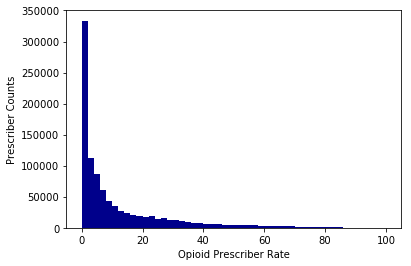

In [43]:
# Distribution of our main outcome variable - opioid_prescriber_rate
plt.hist(df_demo['opioid_prescriber_rate'], bins=50, label='Opioid Prescriber Rate', color=['darkblue'])
plt.ylabel("Prescriber Counts")
plt.xlabel("Opioid Prescriber Rate")

In [66]:
# Remove prescribers that do not prescribe opioids
df_op = df_demo.loc[df_demo['opioid_prescriber_rate'] != 0]
print df_op.shape
df_op['opioid_prescriber_rate'].describe(percentiles=[.25,.33,.67,.75])

(764936, 77)


count    764936.000000
mean         14.517040
std          16.963812
min           0.013272
25%           2.870000
33%           4.000000
50%           7.370000
67%          14.620000
75%          20.590000
max         100.000000
Name: opioid_prescriber_rate, dtype: float64

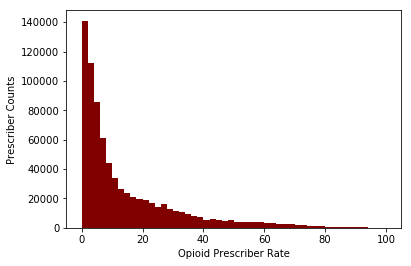

In [83]:
# Distribution of our main outcome variable - opioid_prescriber_rate
plt.hist(df_op['opioid_prescriber_rate'], bins=50, label='Opioid Prescriber Rate', color=['maroon'])
plt.ylabel("Prescriber Counts")
plt.xlabel("Opioid Prescriber Rate")

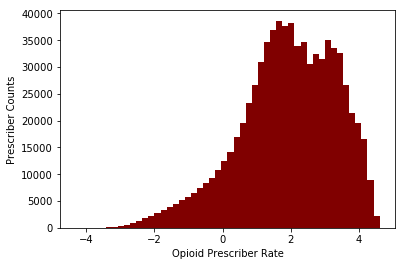

In [85]:
# Distribution of our main outcome variable - log_opr
plt.hist(df_op['log_opr'], bins=50, label='Opioid Prescriber Rate', color=['maroon'])
plt.ylabel("Prescriber Counts")
plt.xlabel("Opioid Prescriber Rate")

,opioid_prescriber_rate,total_claim_count,total_30_day_fill_count,total_drug_cost,total_day_supply,bene_count
opioid_prescriber_rate,1.000000,-0.164230,-0.184898,-0.156511,-0.191204,-0.153609
total_claim_count,-0.164230,1.000000,0.966516,0.605246,0.947335,0.689411
total_30_day_fill_count,-0.184898,0.966516,1.000000,0.584143,0.995362,0.723539
total_drug_cost,-0.156511,0.605246,0.584143,1.000000,0.579354,0.492570
total_day_supply,-0.191204,0.947335,0.995362,0.579354,1.000000,0.717765
bene_count,-0.153609,0.689411,0.723539,0.492570,0.717765,1.000000


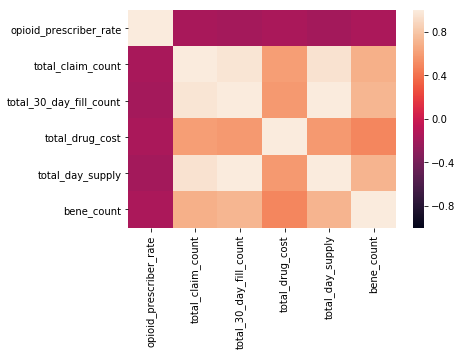

In [97]:
# Looking for correlations with opioid_prescriber_rate
# Use Seaborn to plot a correlation heatmap
df_tmp=df_demo[['opioid_prescriber_rate','total_claim_count','total_30_day_fill_count','total_drug_cost','total_day_supply','bene_count']]
sns.heatmap(df_tmp.corr(), vmin=-1, vmax=1);
df_tmp.corr()

,log_opr,total_claim_count,total_30_day_fill_count,total_drug_cost,total_day_supply,bene_count
log_opr,1.000000,-0.590924,-0.615059,-0.630760,-0.651939,-0.449518
total_claim_count,-0.590924,1.000000,0.995072,0.923561,0.970226,0.904784
total_30_day_fill_count,-0.615059,0.995072,1.000000,0.930037,0.983273,0.890908
total_drug_cost,-0.630760,0.923561,0.930037,1.000000,0.949904,0.786717
total_day_supply,-0.651939,0.970226,0.983273,0.949904,1.000000,0.830190
bene_count,-0.449518,0.904784,0.890908,0.786717,0.830190,1.000000


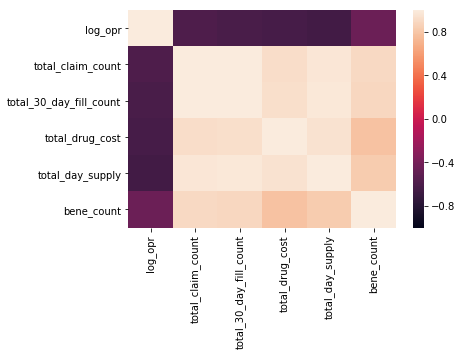

In [111]:
# Looking for correlations with opioid_prescriber_rate
# Use Seaborn to plot a correlation heatmap
df_tmp1=df_op[['log_opr','total_claim_count','total_30_day_fill_count','total_drug_cost','total_day_supply','bene_count']]
sns.heatmap(df_tmp1.corr(method='spearman'), vmin=-1, vmax=1);
df_tmp1.corr(method='spearman')

,log_opr,total_claim_count_ge65,total_30_day_fill_count_ge65,total_drug_cost_ge65,total_day_supply_ge65,bene_count_ge65
log_opr,1.000000,-0.588910,-0.612582,-0.626323,-0.647560,-0.443339
total_claim_count_ge65,-0.588910,1.000000,0.994865,0.923340,0.965911,0.907313
total_30_day_fill_count_ge65,-0.612582,0.994865,1.000000,0.931420,0.979629,0.892048
total_drug_cost_ge65,-0.626323,0.923340,0.931420,1.000000,0.950949,0.794265
total_day_supply_ge65,-0.647560,0.965911,0.979629,0.950949,1.000000,0.828135
bene_count_ge65,-0.443339,0.907313,0.892048,0.794265,0.828135,1.000000


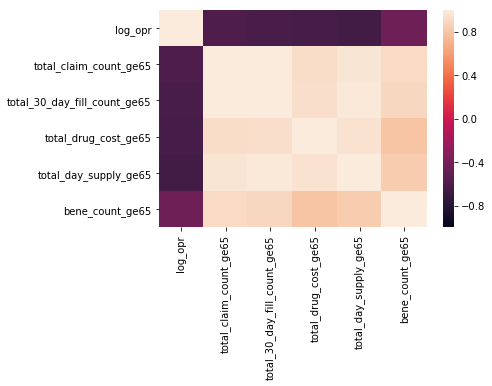

In [110]:
# Looking for correlations with opioid_prescriber_rate
# Use Seaborn to plot a correlation heatmap
df_tmp2=df_op[['log_opr','total_claim_count_ge65','total_30_day_fill_count_ge65','total_drug_cost_ge65','total_day_supply_ge65','bene_count_ge65']]
sns.heatmap(df_tmp2.corr(method='spearman'), vmin=-1, vmax=1);
df_tmp2.corr(method='spearman')

,log_opr,mapd_claim_count,pdp_claim_count,lis_claim_count,nonlis_claim_count,mapd_drug_cost,pdp_drug_cost,lis_drug_cost,nonlis_drug_cost
log_opr,1.000000,-0.502681,-0.567006,-0.523056,-0.531493,-0.559823,-0.608340,-0.578446,-0.577165
mapd_claim_count,-0.502681,1.000000,0.744953,0.820459,0.830293,0.934695,0.697139,0.773728,0.768496
pdp_claim_count,-0.567006,0.744953,1.000000,0.870583,0.864272,0.740541,0.927097,0.838789,0.822802
lis_claim_count,-0.523056,0.820459,0.870583,1.000000,0.733662,0.802868,0.827006,0.934302,0.716526
nonlis_claim_count,-0.531493,0.830293,0.864272,0.733662,1.000000,0.801392,0.799950,0.721995,0.922742
mapd_drug_cost,-0.559823,0.934695,0.740541,0.802868,0.801392,1.000000,0.776627,0.842764,0.839522
pdp_drug_cost,-0.608340,0.697139,0.927097,0.827006,0.799950,0.776627,1.000000,0.900283,0.881494
lis_drug_cost,-0.578446,0.773728,0.838789,0.934302,0.721995,0.842764,0.900283,1.000000,0.784139
nonlis_drug_cost,-0.577165,0.768496,0.822802,0.716526,0.922742,0.839522,0.881494,0.784139,1.000000


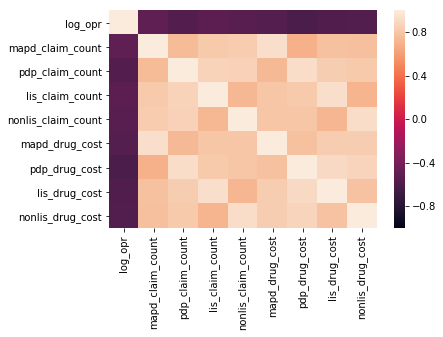

In [109]:
# Looking for correlations with opioid_prescriber_rate
# Use Seaborn to plot a correlation heatmap
df_tmp3=df_op[['log_opr','mapd_claim_count','pdp_claim_count','lis_claim_count','nonlis_claim_count','mapd_drug_cost','pdp_drug_cost','lis_drug_cost','nonlis_drug_cost']]
sns.heatmap(df_tmp3.corr(method='spearman'), vmin=-1, vmax=1);
df_tmp3.corr(method='spearman')

,log_opr,opioid_claim_count,opioid_drug_cost,opioid_day_supply,opioid_bene_count,pct_opioid_bene,opioid_supply_per_bene,opioid_cost_per_bene,opioid_cost_per_claim
log_opr,1.000000,0.257751,0.202602,0.133498,0.345838,0.901910,-0.198759,-0.073331,-0.063761
opioid_claim_count,0.257751,1.000000,0.956004,0.954773,0.937493,0.353340,0.550337,0.608615,0.483698
opioid_drug_cost,0.202602,0.956004,1.000000,0.969005,0.848508,0.289793,0.674060,0.770948,0.680436
opioid_day_supply,0.133498,0.954773,0.969005,1.000000,0.835700,0.233931,0.732233,0.749863,0.625316
opioid_bene_count,0.345838,0.937493,0.848508,0.835700,1.000000,0.461141,0.313384,0.392519,0.325020
pct_opioid_bene,0.901910,0.353340,0.289793,0.233931,0.461141,1.000000,-0.117129,-0.004131,0.009759
opioid_supply_per_bene,-0.198759,0.550337,0.674060,0.732233,0.313384,-0.117129,1.000000,0.893793,0.786334
opioid_cost_per_bene,-0.073331,0.608615,0.770948,0.749863,0.392519,-0.004131,0.893793,1.000000,0.916635
opioid_cost_per_claim,-0.063761,0.483698,0.680436,0.625316,0.325020,0.009759,0.786334,0.916635,1.000000


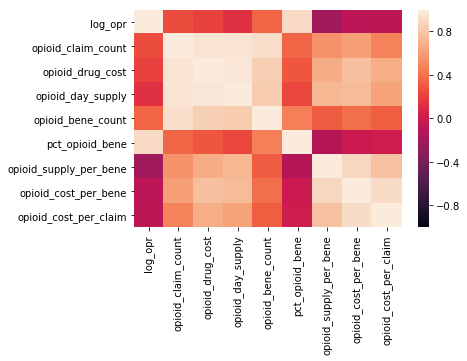

In [108]:
# Looking for correlations with opioid_prescriber_rate
# Use Seaborn to plot a correlation heatmap
df_tmp4=df_op[['log_opr','opioid_claim_count','opioid_drug_cost','opioid_day_supply','opioid_bene_count','pct_opioid_bene','opioid_supply_per_bene','opioid_cost_per_bene','opioid_cost_per_claim']]
sns.heatmap(df_tmp4.corr(method='spearman'), vmin=-1, vmax=1);
df_tmp4.corr(method='spearman')

,log_opr,average_age_of_beneficiaries,pct_bene_female,pct_bene_white
log_opr,1.000000,-0.211545,0.045706,-0.034633
average_age_of_beneficiaries,-0.211545,1.000000,-0.075906,0.298988
pct_bene_female,0.045706,-0.075906,1.000000,-0.010124
pct_bene_white,-0.034633,0.298988,-0.010124,1.000000


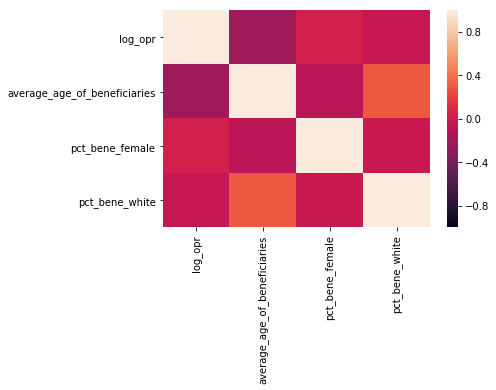

In [107]:
# Looking for correlations with opioid_prescriber_rate
# Use Seaborn to plot a correlation heatmap
df_tmp5=df_op[['log_opr','average_age_of_beneficiaries','pct_bene_female','pct_bene_white']]
sns.heatmap(df_tmp5.corr(method='spearman'), vmin=-1, vmax=1);
df_tmp5.corr(method='spearman')

,log_opr,pct_mapd_claims,pct_lis_claims,claims_per_bene,fill_per_bene,supply_per_bene
log_opr,1.000000,0.038303,-0.014667,-0.606537,-0.630730,-0.646774
pct_mapd_claims,0.038303,1.000000,-0.003775,-0.060211,-0.049632,-0.046693
pct_lis_claims,-0.014667,-0.003775,1.000000,0.182462,0.129096,0.135034
claims_per_bene,-0.606537,-0.060211,0.182462,1.000000,0.986867,0.961226
fill_per_bene,-0.630730,-0.049632,0.129096,0.986867,1.000000,0.982564
supply_per_bene,-0.646774,-0.046693,0.135034,0.961226,0.982564,1.000000


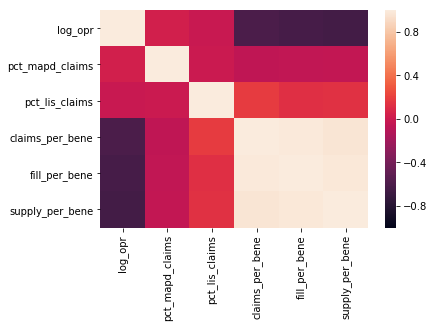

In [106]:
# Looking for correlations with opioid_prescriber_rate
# Use Seaborn to plot a correlation heatmap
df_tmp6=df_op[['log_opr','pct_mapd_claims','pct_lis_claims','claims_per_bene','fill_per_bene','supply_per_bene']]
sns.heatmap(df_tmp6.corr(method='spearman'), vmin=-1, vmax=1);
df_tmp6.corr(method='spearman')

,log_opr,cost_per_bene,cost_per_claim,mapd_cost_per_claim,pdp_cost_per_claim,lis_cost_per_claim,nonlis_cost_per_claim
log_opr,1.000000,-0.610419,-0.519261,-0.517744,-0.512693,-0.523175,-0.489434
cost_per_bene,-0.610419,1.000000,0.865423,0.776292,0.842523,0.813588,0.789147
cost_per_claim,-0.519261,0.865423,1.000000,0.824866,0.952864,0.882819,0.893091
mapd_cost_per_claim,-0.517744,0.776292,0.824866,1.000000,0.721748,0.773857,0.775995
pdp_cost_per_claim,-0.512693,0.842523,0.952864,0.721748,1.000000,0.852994,0.857665
lis_cost_per_claim,-0.523175,0.813588,0.882819,0.773857,0.852994,1.000000,0.705051
nonlis_cost_per_claim,-0.489434,0.789147,0.893091,0.775995,0.857665,0.705051,1.000000


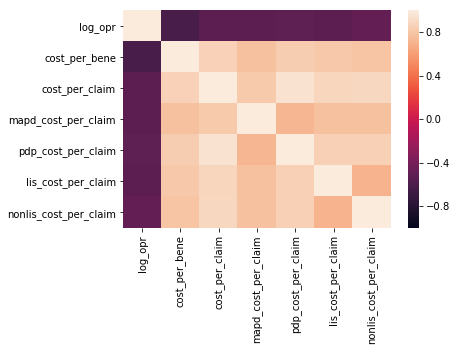

In [105]:
# Looking for correlations with opioid_prescriber_rate
# Use Seaborn to plot a correlation heatmap
df_tmp7=df_op[['log_opr','cost_per_bene','cost_per_claim','mapd_cost_per_claim','pdp_cost_per_claim','lis_cost_per_claim','nonlis_cost_per_claim']]
sns.heatmap(df_tmp7.corr(method='spearman'), vmin=-1, vmax=1);
df_tmp7.corr(method='spearman')

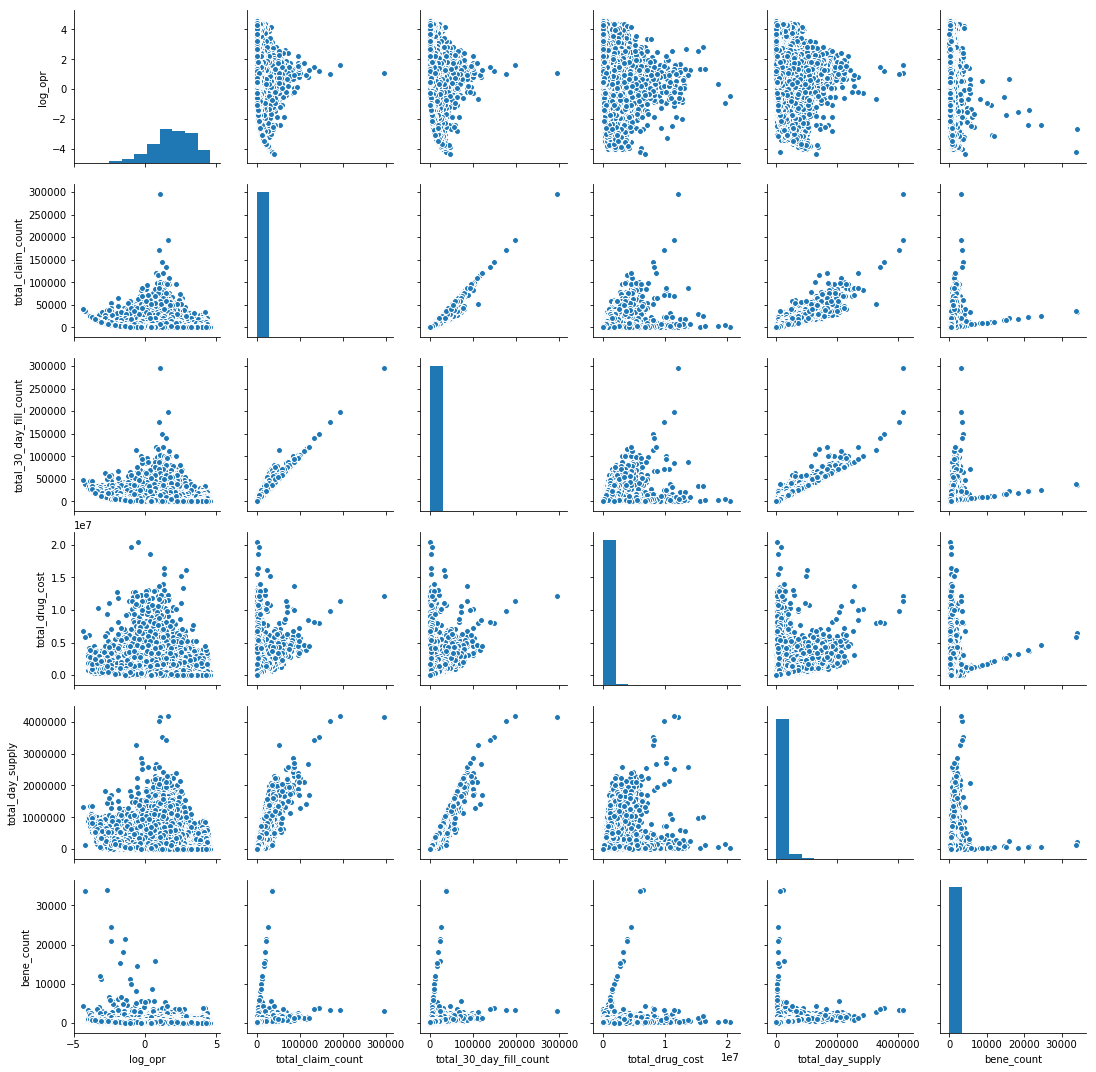

In [112]:
sns.pairplot(df_tmp1);

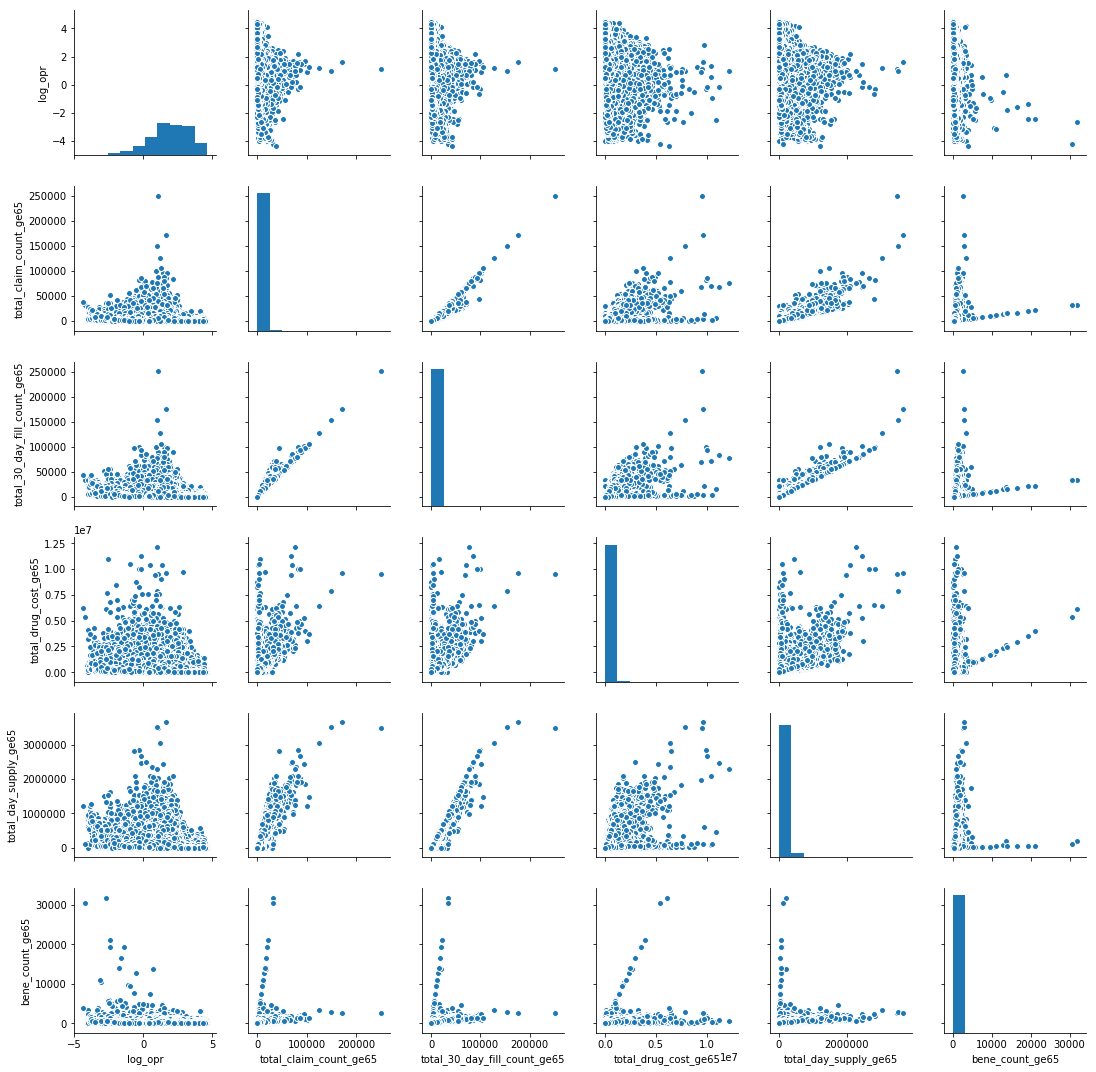

In [113]:
sns.pairplot(df_tmp2);

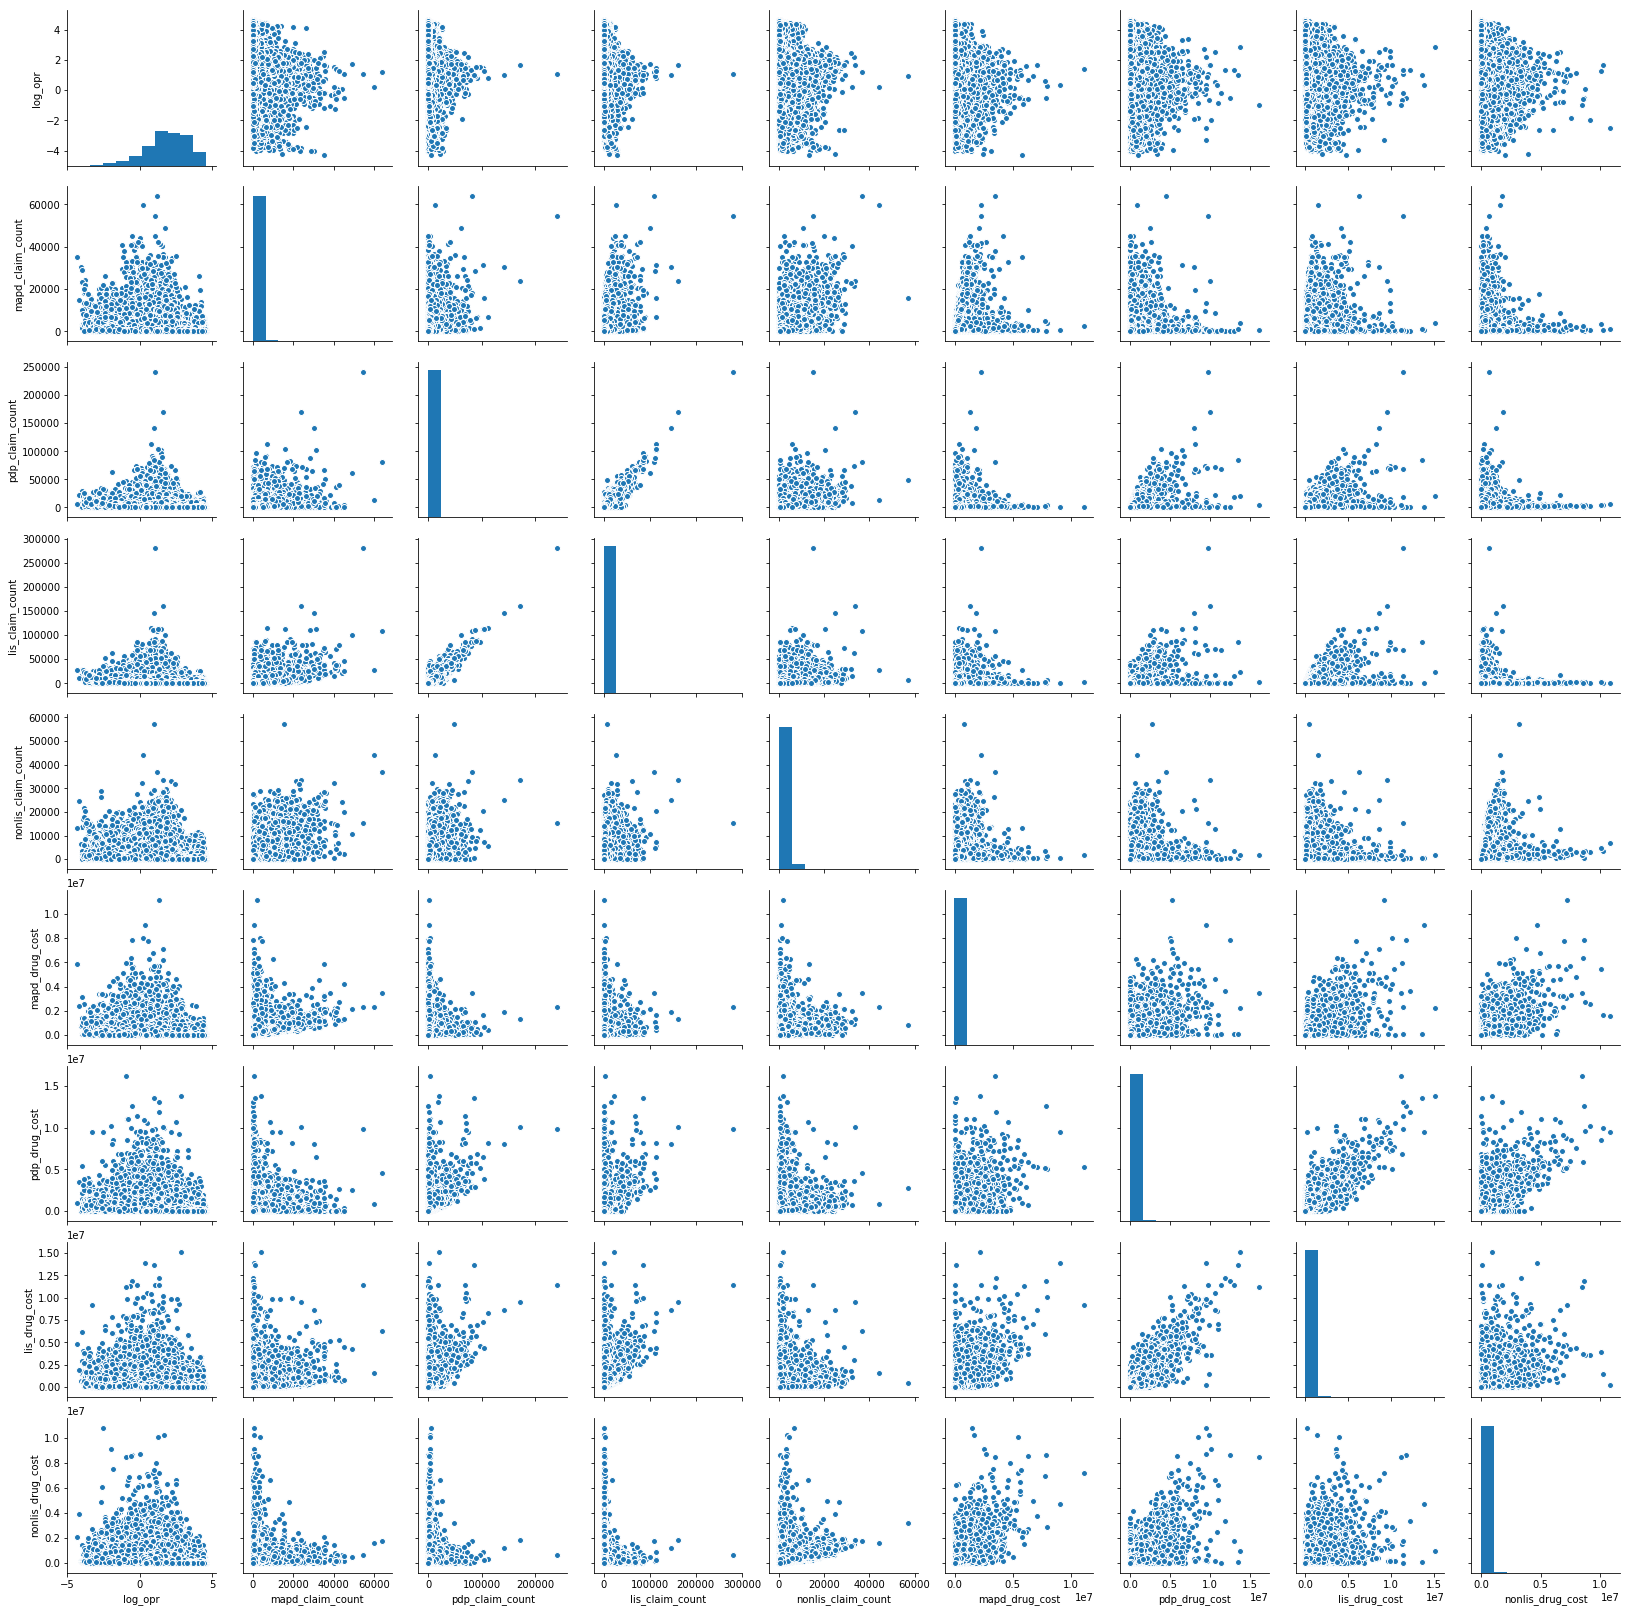

In [114]:
sns.pairplot(df_tmp3);

In [ ]:
sns.pairplot(df_tmp4);

In [ ]:
sns.pairplot(df_tmp5);

In [ ]:
sns.pairplot(df_tmp6);

In [ ]:
sns.pairplot(df_tmp7);

In [ ]:
sns.boxplot()

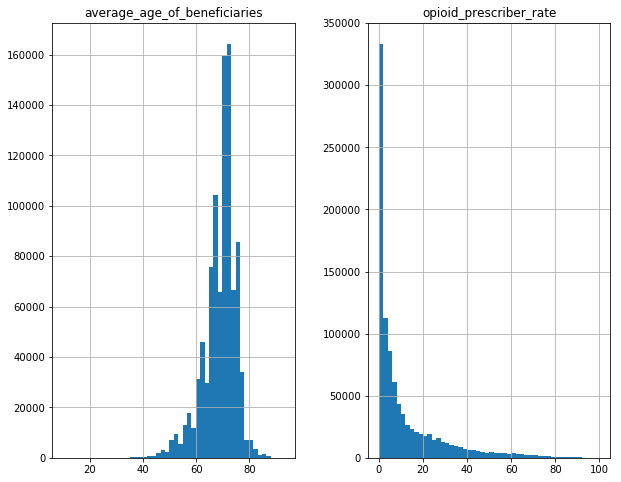

In [292]:
# Plot all variables using histograms
df_demo[['average_age_of_beneficiaries', 'opioid_prescriber_rate']].hist(figsize=(10, 8), bins=50);

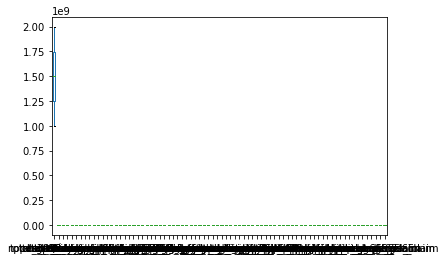

In [293]:
# Plot boxplots 
df_demo.plot.box(showfliers=False);

In [326]:
df_demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958578 entries, 0 to 1102267
Data columns (total 77 columns):
npi                               958578 non-null int64
nppes_provider_gender             958578 non-null object
nppes_provider_city               958578 non-null object
nppes_provider_zip5               958578 non-null float64
nppes_provider_state              958578 non-null object
specialty_description             958578 non-null object
medicare_prvdr_enroll_status      958578 non-null object
total_claim_count                 958578 non-null int64
total_30_day_fill_count           958578 non-null float64
total_drug_cost                   958578 non-null float64
total_day_supply                  958578 non-null int64
bene_count                        958578 non-null float64
ge65_suppress_flag                958578 non-null int64
total_claim_count_ge65            958578 non-null float64
total_30_day_fill_count_ge65      958578 non-null float64
total_drug_cost_ge65           